# Unsupervised Learning for Chemical Tomography: Synthetic XRD-CT Case Study

## 📝 Introduction


This tutorial demonstrates how unsupervised learning methods can be used to explore and analyse chemical tomography datasets, using synthetic data generated with the `nDTomo` package. The goal is to build a foundational understanding of how clustering and dimensionality reduction can help extract meaningful chemical and structural information from X-ray diffraction computed tomography (XRD-CT) datasets.

Rather than working with experimental data, we will use a fully synthetic **phantom XRD-CT dataset** with known ground truth components. This controlled setting allows us to benchmark the performance of different unsupervised methods and gain intuition about their strengths and limitations.

## 🧪 Background: What is Chemical Tomography?

Chemical tomography combines the principles of spatial imaging and spectral analysis. In techniques such as XRD-CT, each spatial voxel or pixel contains a **spectrum** — typically a diffraction pattern — rather than a single scalar intensity value. This results in a 3D data structure with dimensions $(x, y, \text{spectral})$.

In practice, chemical tomography data can be extremely rich but also very high-dimensional and noisy. Therefore, efficient data analysis methods are essential to:
- **Compress** the data (e.g. dimensionality reduction)
- **Identify key features** or patterns (e.g. clustering)
- **Extract chemical maps and reference spectra** without prior labelling

## 🧰 Methods We Will Use

In this notebook, we will explore three widely used unsupervised techniques. These methods are complementary and help answer different questions about the dataset.

### 📌 1. Principal Component Analysis (PCA)

PCA is a **linear dimensionality reduction** technique that transforms a dataset into a new coordinate system defined by directions of maximum variance.

Given a data matrix $X \in \mathbb{R}^{n \times p}$ (e.g., $n$ spectra each with $p$ features), PCA computes:

$$
X = T P^T
$$

- $T$: scores (the projection of the data in the reduced space)
- $P$: loadings (orthogonal vectors capturing directions of maximal variance)

This is equivalent to an eigen-decomposition of the covariance matrix:

$$
\text{Cov}(X) = P \Lambda P^T
$$

where $\Lambda$ is a diagonal matrix of eigenvalues.

PCA assumes linearity and that the directions of maximum variance are the most informative — which might not always be true for chemical mixtures, but it is a fast and useful first approximation.

### 📌 2. Non-negative Matrix Factorisation (NMF)

NMF is particularly suited to chemical data because it respects the non-negative nature of both:
- Spectral intensities
- Spatial concentrations

Given a non-negative data matrix $X \in \mathbb{R}_{+}^{n \times p}$, NMF seeks to approximate it as:

$$
X \approx W H
$$

- $W \in \mathbb{R}_{+}^{n \times k}$: spatial maps (concentrations)
- $H \in \mathbb{R}_{+}^{k \times p}$: spectral components (basis patterns)
- $k$: number of components (e.g. chemical phases)

The key assumption here is that the observed data are additive combinations of a few latent parts. This model aligns very well with how chemical species mix in diffraction or spectroscopic measurements.

NMF is more interpretable than PCA in many cases, especially when the underlying sources are sparse or physically distinct.

### 📌 3. K-Means Clustering

K-means is a widely used **partition-based clustering** method. It attempts to divide a dataset into $k$ clusters by minimising the **within-cluster sum of squares**:

$$
\min_{C} \sum_{i=1}^k \sum_{x \in C_i} \| x - \mu_i \|^2
$$

- $C_i$: the set of points in cluster $i$
- $\mu_i$: the centroid of cluster $i$

K-means makes no assumption about the underlying data distribution — it just finds groups of similar items. It can be applied:
- On spectra (to identify similar diffraction patterns)
- On images (to segment chemical domains)

One limitation is that $k$ must be chosen a priori, and it assumes that clusters are roughly spherical in feature space — which may or may not match the structure of real data.

## 🎯 Objectives

By the end of this tutorial, you will:
- Generate a synthetic XRD-CT phantom with 5 known components
- Apply PCA, NMF, and K-means to extract spatial and spectral features
- Compare algorithm outputs against known ground truth
- Understand the assumptions and trade-offs behind each method

Let’s begin by simulating the synthetic phantom dataset we will use for the rest of the analysis.

## 🧪 Generating a Synthetic XRD-CT Phantom with Known Ground Truth

To evaluate unsupervised learning methods, we need a dataset where the true spatial and spectral components are known. This allows us to quantitatively and visually compare the outputs of PCA, NMF, and K-means against a known reference.

`nDTomo` includes utilities to simulate realistic chemical tomography datasets with user-defined spectra and spatial distributions. We will simulate five chemical components, each defined by:
- A **2D spatial image** representing where the phase is located
- A **diffraction pattern** representing the spectral fingerprint of the phase

By linearly combining these, we generate a **3D volume** with shape $(x, y, q)$ where each pixel contains a synthetic diffraction pattern made of a weighted sum of the five reference patterns.


<KeysViewHDF5 ['Al', 'Cu', 'Fe', 'Pt', 'Zn', 'q', 'tth']>


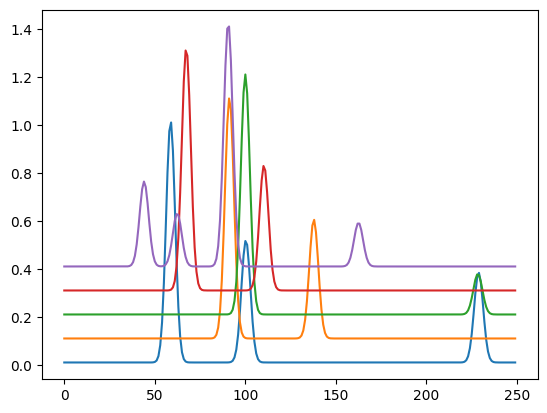

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nDTomo.sim.phantoms import load_example_patterns
from nDTomo.methods.plots import showspectra

# Load synthetic example patterns and associated axes
dpAl, dpCu, dpFe, dpPt, dpZn, tth, q = load_example_patterns()
spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]

# Display the diffraction patterns with vertical offsets
showspectra([dpAl, dpCu + 0.1, dpFe + 0.2, dpPt + 0.3, dpZn + 0.4])

We now create 2D spatial maps for the five chemical components. These serve as the mixing coefficients for each phase in the final volume.

In [6]:
from nDTomo.sim.phantoms import nDTomophantom_2D
from nDTomo.methods.plots import showim

# Image size
npix = 200

# Create 5 distinct phantom images (with non-overlapping shapes)
imAl, imCu, imFe, imPt, imZn = nDTomophantom_2D(npix, nim='Multiple')
iml = [imAl, imCu, imFe, imPt, imZn]

/home/antonyvam/anaconda3/envs/ndtomo/lib/python3.8/site-packages/xdesign/geometry/area.py:789: UserWarning: Didn't check that Mesh contains Circle.
  warnings.warn("Didn't check that Mesh contains Circle.")


Each image is a $200 \times 200$ binary or continuous-valued map indicating the presence of a given chemical phase at each pixel. You can visualise them:

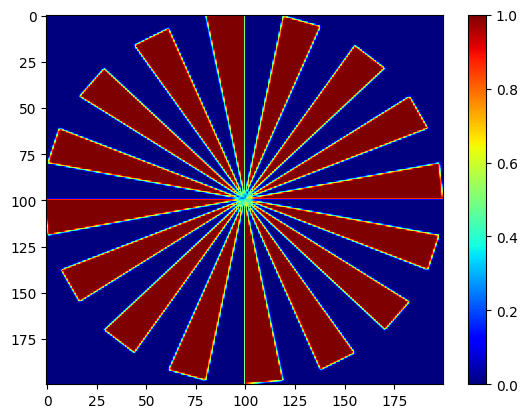

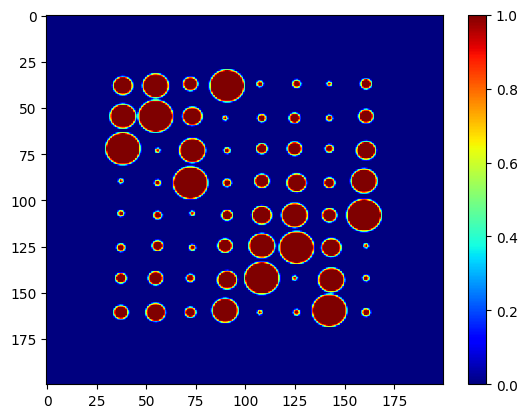

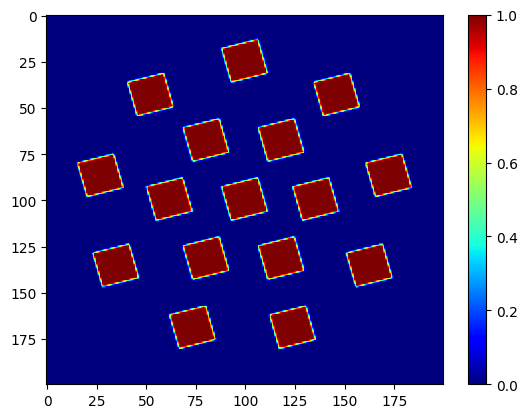

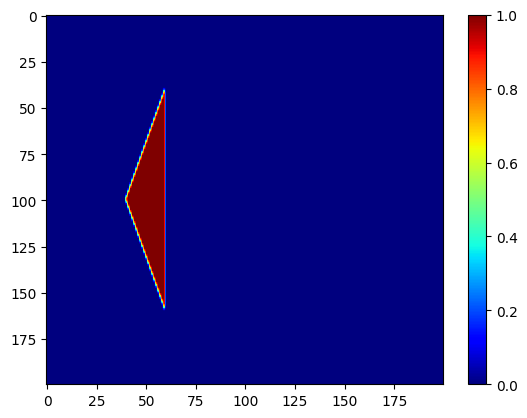

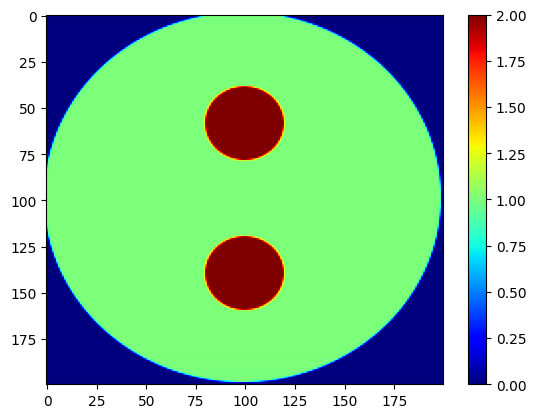

In [7]:
showim(imAl, 2)
showim(imCu, 3)
showim(imFe, 4)
showim(imPt, 5)
showim(imZn, 6)

We now combine the spectra and images into a single 3D dataset using nDphantom_3D. The resulting volume has shape:
(x,y,q)=(200,200,250). This means we have 200×200 spatial pixels, and each pixel contains a synthetic diffraction pattern with 250 data points.

In [8]:
from nDTomo.sim.phantoms import nDTomophantom_3D

chemct = nDTomophantom_3D(npix, use_spectra='Yes', spectra=spectra, imgs=iml, indices='All', norm='No')
print('Simulated chemical volume shape:', chemct.shape)

100%|██████████| 5/5 [00:01<00:00,  4.43it/s]

Simulated chemical volume shape: (200, 200, 250)


We can now interactively explore the spectral content of this volume using the HyperSliceExplorer


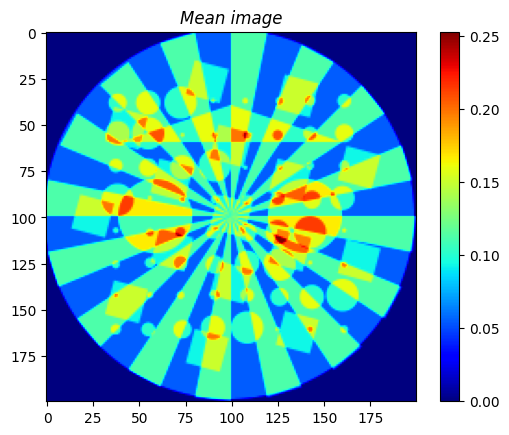

<Figure size 640x480 with 0 Axes>

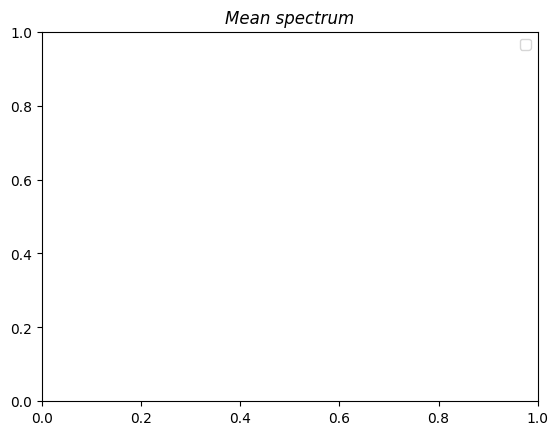

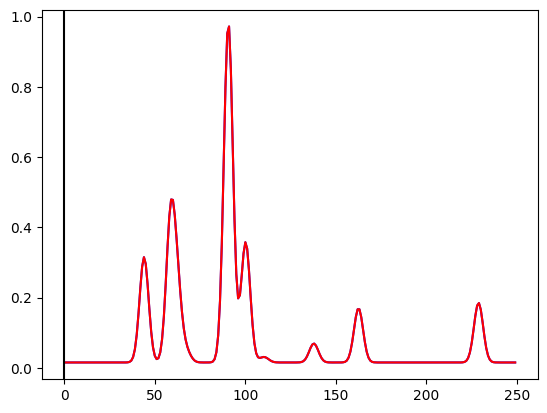

In [ ]:


%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(chemct)